In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tdse.matrix_py import mat_vec_mul_tridiag
from tdse.matrix_py import gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

# Parameter

- may be replaced by input file read

In [3]:
R_in = 50.03
delta_x = 0.2
imag_pot_width = 30.0
delta_t = 0.05
V_x_func = lambda x: np.zeros_like(x)
A_t_func = lambda t: np.zeros_like(t)
t_max_in = 4.98
t0 = 0.0

### Check parameters

In [4]:
assert R_in > 0 and delta_x > 0 and imag_pot_width > 0 and delta_t > 0
from numbers import Integral

# Construct coordinates arrays

## spatial array

In [5]:
N_x = 2 * int(R_in // delta_x) + 1
N_x_width = N_x // 2
# R = R_in - (R_in % delta_x)
R = delta_x * N_x_width
assert R == (R_in - (R_in % delta_x))
x_arr = np.linspace(-R,R,N_x)
assert np.isclose(x_arr[1] - x_arr[0],delta_x, atol=1e-14, rtol=0)

## temporal array

In [6]:
N_timestep = int( (t_max_in - t0 + delta_t) // delta_t )
t_max = t0 + delta_t * N_timestep
N_timepoint = N_timestep + 1
t_arr = np.linspace(t0, t_max, N_timepoint)
assert np.isclose(t_arr[1] - t_arr[0], delta_t, atol=1e-14, rtol=0)
# t_arr = t0 + delta_t * np.arange(N_t)

# Construct potential arrays: $V(x)$, $A(t)$

In [7]:
V_x_arr = V_x_func(x_arr)
A_t_arr = A_t_func(t_arr)

# Construct tridiagonals

## intermediate matrices

In [8]:
tridiag_shape = (3,N_x)
M2 = np.empty(tridiag_shape, dtype=float)
M2[0,1:], M2[1,:], M2[2,:-1] = 1.0/12.0, 10.0/12.0, 1.0/12.0

D2 = np.empty(tridiag_shape, dtype=float)
D2[0,1:], D2[1,:], D2[2,:-1] = 1.0, -2.0, 1.0
D2 *= 1.0 / (delta_x * delta_x)

M2V = np.empty(tridiag_shape, dtype=float)
M2V[0,1:], M2V[1,:], M2V[2,:-1] = M2[0,1:] * V_x_arr[:N_x-1], M2V[1,:] * V_x_arr[:N_x], M2V[2,:-1] * V_x_arr[1:]

M1 = np.empty(tridiag_shape, dtype=float)
M1[0,1:], M1[1,:], M1[2,:-1] = 1.0/4.0, 2.0/3.0, 1.0/4.0

D1 = np.empty(tridiag_shape, dtype=float)
D1[0,1:], D1[1,:], D1[2,:-1] = -1.0, 0.0, 1.0
D1 *= 1.0 / (2.0 * delta_x)

## unitary

- [ ] Later, consider putting the imaginary potential into the real part of the unitary operator

In [9]:
U0_half = np.empty(tridiag_shape, dtype=complex)
U0_half.real = M2
U0_half.imag = - delta_t * 0.5 * (-0.5 * D2 + M2V)

U0 = np.empty(tridiag_shape, dtype=complex)
U0.real = M2
U0.imag = - delta_t * 1.0 * (-0.5 * D2 + M2V)

# Set initial state function

In [10]:
sf_arr_0 = np.empty((N_x,), dtype=complex)
sf_arr = np.empty((N_x,), dtype=complex)

# sf_arr_0[:] = np.exp(-x_arr*x_arr)
from tdse.analytic import Gaussian1D
sf_arr_0[:] = Gaussian1D(x_arr, t0, k_x=0.0)
sf_arr[:] = sf_arr_0.copy()

## Plot

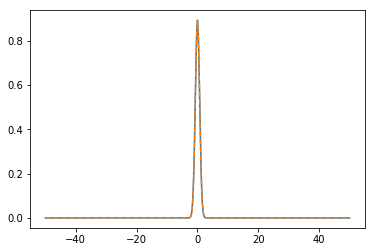

In [11]:
fig_ini, ax_ini = plt.subplots()
ax_ini.plot(x_arr, sf_arr_0.real)
ax_ini.plot(x_arr, np.abs(sf_arr_0), '--')

# Propagation

### Preparation

In [12]:
sf_arr_mid = np.empty_like(sf_arr, dtype=complex)

### Set time

In [13]:
t_idx = 0
t = 0.5 * (t_arr[t_idx] + t_arr[t_idx+1])
A_t = A_t_func(t)

UA = np.empty(tridiag_shape, dtype=complex)
UA.imag = 0.0
UA.real = M1 - delta_t * A_t * D1

tridiag_forward(U0_half, sf_arr, sf_arr_mid)
tridiag_backward(U0_half.conj(), sf_arr, sf_arr_mid)
tridiag_forward(UA, sf_arr, sf_arr_mid)
tridiag_backward(UA.conj(), sf_arr, sf_arr_mid)

for t_idx in range(1,N_timestep):

    t = 0.5 * (t_arr[t_idx] + t_arr[t_idx+1])
    A_t = A_t_func(t)

    UA.real = M1 - delta_t * A_t * D1

    tridiag_forward(U0, sf_arr, sf_arr_mid)
    tridiag_backward(U0.conj(), sf_arr, sf_arr_mid)
    tridiag_forward(UA, sf_arr, sf_arr_mid)
    tridiag_backward(UA.conj(), sf_arr, sf_arr_mid)
    
tridiag_forward(U0_half, sf_arr, sf_arr_mid)
tridiag_backward(U0_half.conj(), sf_arr, sf_arr_mid)

# Analytical result

In [14]:
sf_arr_ana = np.empty_like(sf_arr_0, dtype=complex)
sf_arr_ana[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)

# Visualization

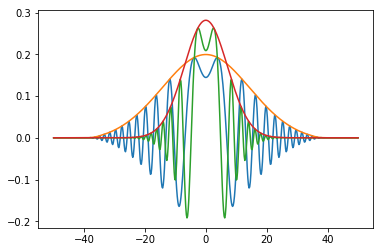

In [15]:
fig, ax = plt.subplots()

ax.plot(x_arr, sf_arr.real)
ax.plot(x_arr, np.abs(sf_arr))

ax.plot(x_arr, sf_arr_ana.real)
ax.plot(x_arr, np.abs(sf_arr_ana))